In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df = pd.read_excel("C:/Users/gvrk1/Downloads/EV CLEAN DATASET.xlsx")

In [14]:
df.head()

,S.NO,FUEL,COLOR,VEHICLE CLASS CATEGORY,CATEGORY,BRAND,RTO-OFFICE,DISTRICT,REG.DATE,YEAR,MONTH
0,1,EV,ADAPT GREEN,3W Electric,Transport,ADAPT,RTA MANCHERIAL,Mancherial,2019-01-01,2019,January
1,2,EV,ADAPT GREEN,3W Electric,Transport,ADAPT,RTA NAGARKURNOOL,Nagarkurnool,2019-01-01,2019,January
2,3,EV,MEGNA GREY,2W,Non Transport,OKINAWA,RTA RANGAREDDY,Ranga Reddy,2019-01-01,2019,January
3,4,EV,ADAPT GREEN,3W Electric,Transport,ADAPT,RTA MANCHERIAL,Mancherial,2019-01-02,2019,January
4,5,EV,MEGNA GREY,2W,Non Transport,OKINAWA,RTA RANGAREDDY,Ranga Reddy,2019-01-02,2019,January


In [ ]:
# Convert REG.DATE to datetime
df['REG.DATE'] = pd.to_datetime(df['REG.DATE'])

# Create year and month numeric columns
df['YEAR'] = df['REG.DATE'].dt.year
df['MONTH_NUM'] = df['REG.DATE'].dt.month

# Group by Year + Month and count registrations
monthly_data = df.groupby([df['REG.DATE'].dt.year, df['REG.DATE'].dt.month]).size().reset_index(name='EV_REGISTRATIONS')
monthly_data.columns = ['YEAR', 'MONTH', 'EV_REGISTRATIONS']


In [15]:
df['REG.DATE'] = pd.to_datetime(df['REG.DATE'])

In [16]:
# Create year and month numeric columns
df['YEAR'] = df['REG.DATE'].dt.year
df['MONTH_NUM'] = df['REG.DATE'].dt.month

In [10]:
# Group by Year + Month and count registrations
monthly_data = df.groupby([df['REG.DATE'].dt.year.rename('YEAR'),
                           df['REG.DATE'].dt.month.rename('MONTH')]).size().reset_index(name='EV_REGISTRATIONS')


In [11]:
# Sort by year and month 
monthly_data = monthly_data.sort_values(by=['YEAR', 'MONTH'])

# Create lag feature
monthly_data['PREV_MONTH_REG'] = monthly_data['EV_REGISTRATIONS'].shift(1)

# Drop the first row (NaN in PREV_MONTH_REG)
monthly_data = monthly_data.dropna()


In [12]:
from sklearn.model_selection import train_test_split

X = monthly_data[['YEAR', 'MONTH', 'PREV_MONTH_REG']]
y = monthly_data['EV_REGISTRATIONS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("✅ RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("✅ R2 Score:", r2_score(y_test, y_pred))


✅ RMSE: 1827.7712170051748
✅ R2 Score: -2.4132171080296794


C:\Users\gvrk1\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
# Grab the last available row to predict next month
latest = monthly_data.iloc[-1]

next_month = {
    'YEAR': latest['YEAR'] if latest['MONTH'] < 12 else latest['YEAR'] + 1,
    'MONTH': latest['MONTH'] + 1 if latest['MONTH'] < 12 else 1,
    'PREV_MONTH_REG': latest['EV_REGISTRATIONS']
}

import pandas as pd
next_month_df = pd.DataFrame([next_month])
future_prediction = model.predict(next_month_df)

print(f" Predicted EV Registrations for {next_month['MONTH']}-{next_month['YEAR']}:", round(future_prediction[0]))


 Predicted EV Registrations for 7.0-2025.0: 8581


In [23]:

latest = monthly_data.iloc[-1]


months_to_predict = 18  # Jul 2025 to Dec 2026 = 18 months

future_months = []

for _ in range(months_to_predict):
    next_month = {
        'YEAR': latest['YEAR'] if latest['MONTH'] < 12 else latest['YEAR'] + 1,
        'MONTH': latest['MONTH'] + 1 if latest['MONTH'] < 12 else 1,
        'PREV_MONTH_REG': latest['EV_REGISTRATIONS']
    }

    next_month_df = pd.DataFrame([next_month])
    prediction = model.predict(next_month_df)[0]

    # Store prediction
    future_months.append({
        'YEAR': next_month['YEAR'],
        'MONTH': next_month['MONTH'],
        'EV_REGISTRATIONS': round(prediction)
    })

    
    latest = next_month.copy()
    latest['EV_REGISTRATIONS'] = prediction

# Convert to DataFrame
future_df = pd.DataFrame(future_months)
display(future_df)


,YEAR,MONTH,EV_REGISTRATIONS
0,2025.0,7.0,8581
1,2025.0,8.0,9239
2,2025.0,9.0,9558
3,2025.0,10.0,9722
4,2025.0,11.0,9817
5,2025.0,12.0,9880
6,2026.0,1.0,10635
7,2026.0,2.0,10997
8,2026.0,3.0,11182
9,2026.0,4.0,11285


In [24]:
full_data_with_predictions = pd.concat([monthly_data, future_df], ignore_index=True)


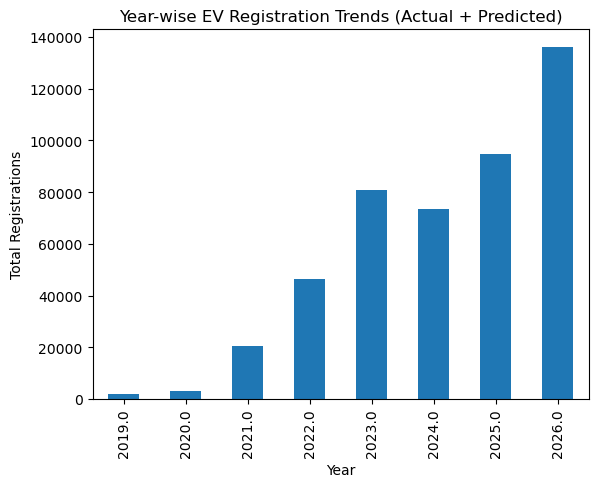

In [25]:
import matplotlib.pyplot as plt

full_data_with_predictions.groupby('YEAR')['EV_REGISTRATIONS'].sum().plot(kind='bar')
plt.title("Year-wise EV Registration Trends (Actual + Predicted)")
plt.ylabel("Total Registrations")
plt.xlabel("Year")
plt.show()


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming you already have y_test and y_pred
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


MAE: 1599.6053306430733
RMSE: 1827.7712170051748
R² Score: -2.4132171080296794


In [27]:
df['YEAR'] = df['REG.DATE'].dt.year
df['MONTH'] = df['REG.DATE'].dt.month

monthly_data = df.groupby(['YEAR', 'MONTH']).size().reset_index(name='EV_REGISTRATIONS')


In [28]:
X = monthly_data[['YEAR', 'MONTH']]  # features
y = monthly_data['EV_REGISTRATIONS']  # target


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)


MAE: 748.506
RMSE: 1373.84038417132
R² Score: 0.7769848703316851


In [32]:
# Generate future months
future_dates = pd.date_range(start='2025-07-01', end='2026-12-01', freq='MS')

# Create DataFrame with YEAR and MONTH
future_df = pd.DataFrame({
    'YEAR': future_dates.year,
    'MONTH': future_dates.month
})


In [33]:
future_preds = model.predict(future_df)
future_df['PREDICTED_EV_REGISTRATIONS'] = future_preds.astype(int)


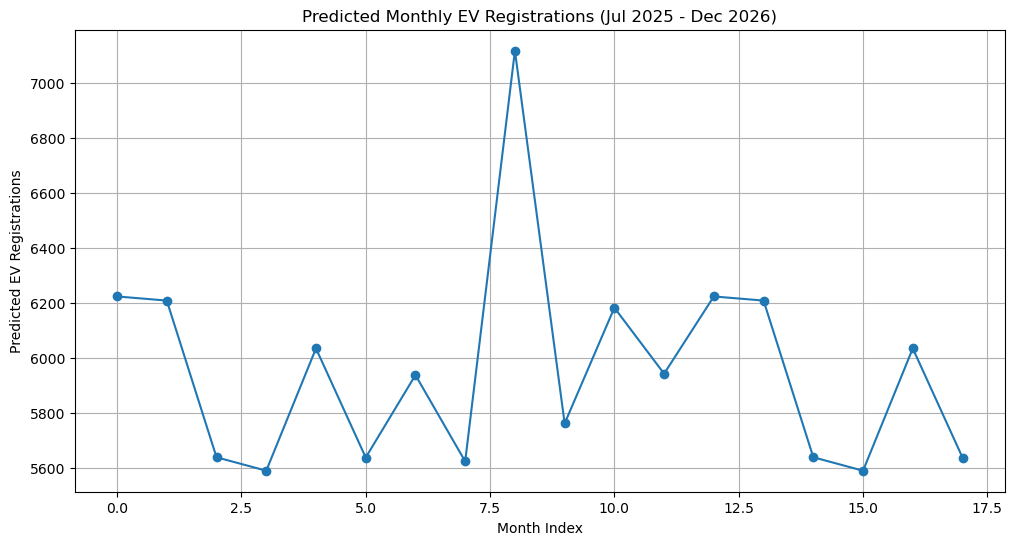

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(future_df['PREDICTED_EV_REGISTRATIONS'], marker='o')
plt.title('Predicted Monthly EV Registrations (Jul 2025 - Dec 2026)')
plt.xlabel('Month Index')
plt.ylabel('Predicted EV Registrations')
plt.grid()
plt.show()


In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Features and target
X = monthly_data[['YEAR', 'MONTH']]
y = monthly_data['EV_REGISTRATIONS']



In [38]:
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)


In [39]:
# future date range
future_months_range = pd.date_range(start='2025-07-01', end='2026-12-01', freq='MS')

# features for prediction
future_months_df = pd.DataFrame({
    'YEAR': future_months_range.year,
    'MONTH': future_months_range.month
})

# Predict future values
y_pred_rf_future = rf.predict(future_months_df)


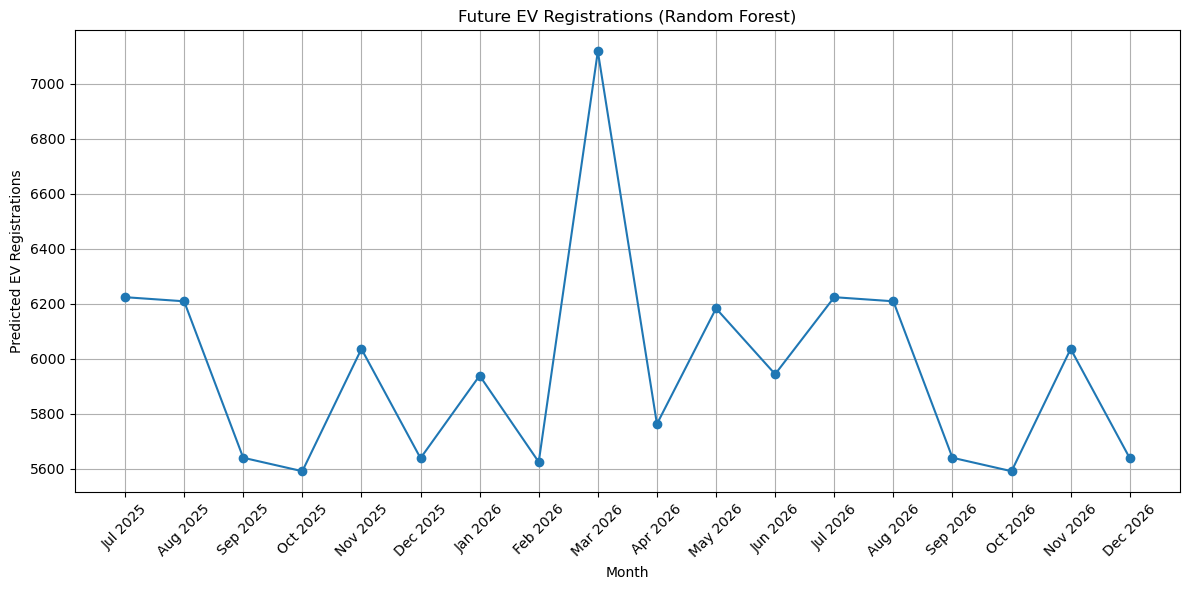

In [40]:
# Month labels like "Jul 2025.."
future_month_labels = future_months_range.strftime('%b %Y')


plt.figure(figsize=(12, 6))
plt.plot(future_month_labels, y_pred_rf_future, marker='o')
plt.title('Future EV Registrations (Random Forest)')
plt.xlabel('Month')
plt.ylabel('Predicted EV Registrations')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
